In [1]:
# pip install
!pip install -r requirements.txt

# Imports
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from pprint import pprint

# Module imports
from periodic_table import *
from utils import *
print("Imported all.")

Imported all.


In [31]:
# Open propmt TPC data file
file_dir = "./assets/A_Z_count-TPC_prompt.txt"
columns = ["Mass Number", "Atomic Number", "Counts"]
df_prompt = open_data(file_dir, columns)
# Add in isotope data
add_isotope_data(df_prompt)
# Reorder columns
df_prompt = df_prompt[["Symbol","Iso Symbol","Atomic Number","Mass Number","Counts","Production Yield","Stable","Half Life","Decay Modes (m, b, q MeV)","Plot Colour",]]
# df_prompt.tail(20)

In [30]:
# Open delayed TPC data file
file_dir = "./assets/A_Z_count-TPC_delayed.txt"
columns = ["Mass Number", "Atomic Number", "Counts"]
df_delayed = open_data(file_dir, columns)
# Add in isotope data
add_isotope_data(df_delayed)
# Reorder columns
df_delayed = df_delayed[["Symbol","Iso Symbol","Atomic Number","Mass Number","Counts","Production Yield","Stable","Half Life","Decay Modes (m, b, q MeV)","Plot Colour",]]
# df_delayed.tail(20)

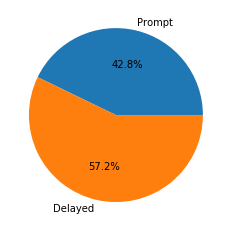

In [8]:
# Ratio of prompt to delayed counts
plt.pie(x=[df_prompt["Counts"].sum(), df_delayed["Counts"].sum()], autopct='%1.1f%%', labels=["Prompt", "Delayed"])
plt.show()

In [29]:
# Open buffer data file
file_dir = "./assets/A_Z_count-buffers.txt"
columns = ["Mass Number", "Atomic Number", "Counts"]
df_buffers = open_data(file_dir, columns)
# Add in isotope data
add_isotope_data(df_buffers)
# Reorder columns
df_buffers = df_buffers[["Symbol","Iso Symbol","Atomic Number","Mass Number","Counts","Production Yield","Stable","Half Life","Decay Modes (m, b, q MeV)","Plot Colour",]]
# df_buffers.tail(20)

In [27]:
# Creates LaTeX table
print(df_prompt.to_latex(index=False))

\begin{tabular}{lllllrlrll}
\toprule
Symbol & Iso Symbol & Atomic Number & Mass Number &  Counts &  Production Yield &  Stable &    Half Life &                          Decay Modes (m, b, q MeV) & Plot Colour \\
\midrule
     H &      H 1-4 &             1 &           4 &     624 &      1.099695e-04 &   False & 0.000000e+00 &                                   [[N, 1.0, 2.88]] &         red \\
     H &      H 1-5 &             1 &           5 &       1 &      1.762331e-07 &   False & 8.330000e-23 &                                   [[2N, 1.0, 1.8]] &         red \\
     H &      H 1-6 &             1 &           6 &       1 &      1.762331e-07 &   False & 2.970000e-22 &                                    [[N, 1.0, 0.9]] &         red \\
    He &     He 2-5 &             2 &           5 &       4 &      7.049325e-07 &   False & 7.910000e-22 &                   [[A, 1.0, 0.89], [N, 1.0, 0.89]] &         red \\
    He &     He 2-6 &             2 &           6 &    1279 &      2.254022e-04

In [28]:
print(df_delayed.to_latex(index=False))

\begin{tabular}{lllllrlrll}
\toprule
Symbol & Iso Symbol & Atomic Number & Mass Number &  Counts &  Production Yield &  Stable &    Half Life &                          Decay Modes (m, b, q MeV) & Plot Colour \\
\midrule
    He &     He 2-5 &             2 &           5 &       3 &      3.958421e-07 &   False & 7.910000e-22 &                   [[A, 1.0, 0.89], [N, 1.0, 0.89]] &         red \\
    Li &     Li 3-6 &             3 &           6 &     695 &      9.170341e-05 &    True &          inf &                                               None &        blue \\
    Li &     Li 3-7 &             3 &           7 &     291 &      3.839668e-05 &    True &          inf &                                               None &        blue \\
    Li &     Li 3-8 &             3 &           8 &      29 &      3.826473e-06 &   False & 8.400000e-01 &                [[B-, 1.0, 16.005], [BA, 1.0, 0.0]] &         red \\
    Be &     Be 4-8 &             4 &           8 &     323 &      4.261900e-05

In [16]:
# Creates LaTeX table
print(df_buffers.to_latex(index=False))

\begin{tabular}{lllllrlrll}
\toprule
Symbol & Iso Symbol & Atomic Number & Mass Number &  Counts &  Production Yield &  Stable &    Half Life &                          Decay Modes (m, b, q MeV) & Plot Colour \\
\midrule
     H &      H 1-4 &             1 &           4 &    1434 &      5.933434e-05 &   False & 0.000000e+00 &                                   [[N, 1.0, 2.88]] &         red \\
     H &      H 1-5 &             1 &           5 &       5 &      2.068840e-07 &   False & 8.330000e-23 &                                   [[2N, 1.0, 1.8]] &         red \\
     H &      H 1-6 &             1 &           6 &       5 &      2.068840e-07 &   False & 2.970000e-22 &                                    [[N, 1.0, 0.9]] &         red \\
    He &     He 2-5 &             2 &           5 &      20 &      8.275361e-07 &   False & 7.910000e-22 &                   [[A, 1.0, 0.89], [N, 1.0, 0.89]] &         red \\
    He &     He 2-6 &             2 &           6 &    2614 &      1.081590e-04